### VGGNet简介
+ **作者**： Visual Geometry Group And Google DeepMind
+ **特点**： 探索了卷积神经网络的深度与其性能之间的关系，扩展性强，迁移到其他图片数据上的泛化性非常好。
+ **结构**： 反复堆叠3X3的小型卷积核和2X2的最大池化层，成功构筑了16~19层深的卷积神经网络。
+ **成就**： ILSVRC 2014比赛分类项目第二名，定位项目第一名

同时，VGGNet训练后的模型参数在其官方网站上开源了，可用来在domain specific的图像分类任务上进行再训练。

VGGNet论文中全部使用了3X3卷积核和2X2池化核，通过不断加深网络结构来提升性能。

下面是VGG六种不同类型的神经网络的模型。
![VGGNet网络结构图](img/VGGNet.png)

下面是六种类型神经网络模型的参数量
![VGGNetVariable](img/VGGNetVariable.png)

VGGNet有5段卷积，每段内的卷积核数量一样，越靠后的卷积核数量越多，64-128-512-512. 其中经常有完全一样的3X3的卷积层堆叠在一起的情况。

这其实是一个非常有用的设计，两个3X3的卷积层相当于一个5X5的卷积层。
![3_2conv](img/3_2Conv.png)
因为，在第二个3X3卷积层处理完成之后，在原图像上面相当于处理了一个5X5的区域。同理，三个串联的3X3卷积层相当于一个7X7的卷积层。但是，3个3X3的卷积层拥有更少的参数量，只有7X7参数量的\\(\frac{3\times 3\times 3}{7\times 7}=55\%\\),**不过！相比较来说7X7的卷积核的运算量没有三个3X3的运算量大**。更重要的是，3个3X3的卷积层拥有比1个7X7的卷积层更多的非线性变换（前者使用三次ReLU激活函数，而后者只使用一次），使得CNN对特征的学习能力更强。

VGGNet在训练时有一个小技巧，先训练级别A的简单网络，再复用A网络的权重来初始化后面的几个复杂模型，这样训练收敛速度更快。

预测时，VGG采用Multi-Scale的方法，将图像Scale到一个尺寸Q，并将图片输入卷积网络计算，然后在最后一个卷积层使用滑窗的方式进行分类 预测，将不同窗口的分类 结果平均，再将不同尺寸Q的结果平均得到最后结果，这样可以提高图片数据的利用率并提升准确率。

VGGNet作者对比各级网络总结如下观点
+ LRN层作用不大
+ 越深的网络效果越好
+ 1X1的卷积也是有效的，但是没有3X3的卷积好，大一些的卷积核可以学习更大的空间特征。
![error_rate](img/error_rate.png)

因为训练耗费时间太长，因此，同理，使用评测模型运行时间的方式来评测模型。

**下面，实现VGGNet-16，即版本D**

第一步，导包

In [13]:
from datetime import datetime
import math
import time
import tensorflow as tf
import matplotlib.pyplot as plt

In [15]:
def print_activations(t):
    print(t.op.name, " ", t.get_shape().as_list())

定义创建卷积层的函数，这个函数包括如下几个参数：
+ **input_op** 卷积层的输入节点
+ **name** 卷积层的名称
+ **kh & kw** 卷积核的大小， 宽和高(对VGGNet来说一般都是3）
+ **n_out** 卷积层的输出通道数（对VGGNet来说一般都是逐级递增）
+ **dh & dw** 卷积核卷积的步长
+ **p** 参数的集合，用来保存模型参数

这里的卷积层的操作包括
1. 获取上一层的输出通道数
2. 根据输入通道数和输出通道数以及步长进行卷积
3. 添加偏置
4. ReLU激活函数 

In [16]:
def conv_op(input_op, name, kh, kw, n_out, dh, dw, p):
    n_in = input_op.get_shape()[-1].value
    
    with tf.name_scope(name) as scope:
        kernel = tf.get_variable(scope + "w", 
                                 shape=[kh, kw, n_in, n_out], 
                                 dtype=tf.float32, 
                                 initializer=tf.contrib.layers.xavier_initializer_conv2d())
        conv = tf.nn.conv2d(input_op, kernel, 
                            strides=[1,dh, dw, 1], 
                            padding='SAME')
        bias_init_val = tf.constant(0.0, shape=[n_out], dtype=tf.float32)
        biases = tf.Variable(bias_init_val, trainable=True, name='b')
        z = tf.nn.bias_add(conv, biases)
        activation = tf.nn.relu(z, name = scope)
        p += [kernel, biases]
        print_activations(activation)
        return activation

初始化全连接层。
这里的参数包括
+ **input_op** 全连接层的输入节点
+ **name** 全连接层的名称
+ **n_out** 全连接层的输出节点个数
+ **p** 参数的集合，用来保存模型参数

这一层的操作包括：
1. 获取上一层的输出维度
2. 创建全连接层的权重和偏置参数
3. 使用ReLU激活函数
4. 添加参数到参数列表

*(对于这里添加激活函数直接写成ReLU激活函数我不是特别理解，感觉如果把激活函数也作为是一个参数就好了，因为如果最后一层是Softmax激活函数，或者是做概率分析的Sigmoid激活函数的话，这里的ReLU激活函数感觉会变得多余。尽管在这个例子中，作者在最后一层的处理方式是在ReLU激活函数后面添加了一个Softmax操作，但是，感觉这样不是很好)*

In [17]:
def fc_op(input_op, name, n_out, p):
    n_in = input_op.get_shape()[-1].value
    
    with tf.name_scope(name) as scope:
        kernel = tf.get_variable(scope + "w", 
                                 shape = [n_in, n_out], 
                                 dtype=tf.float32, 
                                 initializer=tf.contrib.layers.xavier_initializer())
        biases = tf.Variable(
            tf.constant(0.1, shape=[n_out], dtype=tf.float32), 
            name='b')
        activation = tf.nn.relu_layer(input_op, kernel, biases, name = scope)
        p += [kernel, biases]
        print_activations(activation)
        return activation

创建池化层的函数，这里的参数包括
+ **input_op** 池化层输入节点
+ **name** 池化层名称
+ **kh & kw** 池化核大小
+ **dh & dw** 池化步长

操作包括
+ 最大池化操作

In [18]:
def mpool_op(input_op, name, kh, kw, dh, dw):
    activation =  tf.nn.max_pool(input_op,
                          ksize = [1, kh, kw, 1],
                          strides=[1, dh, dw, 1],
                          padding = 'SAME',
                          name = name)
    print_activations(activation)
    return activation

定义VGGNet-16网络结构，VGGNet16的网络结构可以在上面的列表中找到，因此，下面的创建过程就不在赘述了。

In [19]:
def inference_op(input_op, keep_prob):
    p = []
    
    conv1_1 = conv_op(input_op, name="conv1_1", kh=3, kw=3, n_out=64, dh=1, dw=1, p=p)
    conv1_2 = conv_op(conv1_1, name="conv1_2", kh=3, kw=3, n_out=64, dh=1, dw=1, p=p)
    pool1 = mpool_op(conv1_2, name="pool1", kh=2, kw=2, dh=2, dw=2)
    
    conv2_1 = conv_op(pool1, name="conv2_1", kh=3, kw=3, n_out=128, dh=1, dw=1, p=p)
    conv2_2 = conv_op(conv2_1, name="conv2_2", kh=3, kw=3, n_out=128, dh=1, dw=1, p=p)
    pool2 = mpool_op(conv2_2, name="pool2", kh=2, kw=2, dh=2, dw=2)
    
    conv3_1 = conv_op(pool2, name="conv3_1", kh=3, kw=3, n_out=256, dh=1, dw=1, p=p)
    conv3_2 = conv_op(conv3_1, name="conv3_2", kh=3, kw=3, n_out=256, dh=1, dw=1, p=p)
    conv3_3 = conv_op(conv3_2, name="conv3_3", kh=3, kw=3, n_out=256, dh=1, dw=1, p=p)
    pool3 = mpool_op(conv3_3, name="pool3", kh=2, kw=2, dh=2, dw=2)
    
    conv4_1 = conv_op(pool3, name="conv4_1", kh=3, kw=3, n_out=512, dh=1, dw=1, p=p)
    conv4_2 = conv_op(conv4_1, name="conv4_2", kh=3, kw=3, n_out=512, dh=1, dw=1, p=p)
    conv4_3 = conv_op(conv4_2, name="conv4_3", kh=3, kw=3, n_out=512, dh=1, dw=1, p=p)
    pool4 = mpool_op(conv4_3, name="pool4", kh=2, kw=2, dh=2, dw=2)
    
    conv5_1 = conv_op(pool4, name="conv5_1", kh=3, kw=3, n_out=512, dh=1, dw=1, p=p)
    conv5_2 = conv_op(conv5_1, name="conv5_2", kh=3, kw=3, n_out=512, dh=1, dw=1, p=p)
    conv5_3 = conv_op(conv5_2, name="conv5_3", kh=3, kw=3, n_out=512, dh=1, dw=1, p=p)
    pool5 = mpool_op(conv5_3, name="pool5", kh=2, kw=2, dh=2, dw=2)
    
    shp = pool5.get_shape()
    flattened_shape = shp[1].value * shp[2].value * shp[3].value
    resh1 = tf.reshape(pool5, [-1, flattened_shape], name="resh1")
    
    fc6 = fc_op(resh1, name="fc6", n_out=4096, p=p)
    fc6_drop = tf.nn.dropout(fc6, keep_prob=keep_prob, name="fc6_drop")
    
    fc7 = fc_op(fc6_drop, name="fc7", n_out=4096, p=p)
    fc7_drop = tf.nn.dropout(fc7, keep_prob=keep_prob, name="fc7_drop")
    
    fc8 = fc_op(fc7_drop, name="fc8", n_out=1000, p=p)
    softmax = tf.nn.softmax(fc8)
    
    predictions = tf.argmax(softmax, 1)
    return predictions, softmax, fc8, p    

In [21]:
# 打印网络结构
_,_1,_2,_3 = inference_op(tf.random_normal(shape=[32, 224, 224, 3],dtype=tf.float32), 1.0)

conv1_1_2   [32, 224, 224, 64]
conv1_2_2   [32, 224, 224, 64]
pool1_2   [32, 112, 112, 64]
conv2_1_2   [32, 112, 112, 128]
conv2_2_2   [32, 112, 112, 128]
pool2_2   [32, 56, 56, 128]
conv3_1_2   [32, 56, 56, 256]
conv3_2_2   [32, 56, 56, 256]
conv3_3_2   [32, 56, 56, 256]
pool3_2   [32, 28, 28, 256]
conv4_1_2   [32, 28, 28, 512]
conv4_2_2   [32, 28, 28, 512]
conv4_3_2   [32, 28, 28, 512]
pool4_2   [32, 14, 14, 512]
conv5_1_2   [32, 14, 14, 512]
conv5_2_2   [32, 14, 14, 512]
conv5_3_2   [32, 14, 14, 512]
pool5_2   [32, 7, 7, 512]
fc6_2   [32, 4096]
fc7_2   [32, 4096]
fc8_2   [32, 1000]


下面的代码和之前的AlexNet网络评测的代码几乎没有什么区别，因此也不再赘述。

In [6]:
def time_tensorflow_run(session, target, feed, info_string):
    durations = []
    steps = []
    num_steps_burn_in = 10
    total_duration = 0.
    total_duration_squared = 0.
    for i in range(num_batches + num_steps_burn_in):
        start_time = time.time()
        _ = session.run(target, feed_dict=feed)
        duration = time.time() - start_time
        if i >= num_steps_burn_in:
            #print('%s: step %d, duration = %.3f' % (datetime.now(), i-num_steps_burn_in, duration))
            durations.append(duration)
            steps.append(i - num_steps_burn_in)
            total_duration += duration
            total_duration_squared += duration * duration
    mn = total_duration / num_batches
    vr = total_duration_squared / num_batches - mn * mn
    sd = math.sqrt(vr)
    plt.plot(steps, durations)
    plt.xlabel("setp")
    plt.ylabel("duration/sec")
    plt.title(info_string)
    plt.show()
    print("%s:%s across %d steps, %.3f +/- %.3f sec / batch" %(datetime.now(), info_string, num_batches, mn, sd))

In [7]:
def run_benchmark():
    with tf.Graph().as_default():
        image_size = 224
        images = tf.Variable(
            tf.random_normal([batch_size,image_size,image_size,3],
                             dtype=tf.float32, 
                             stddev=0.1))
        keep_prob = tf.placeholder(tf.float32)
        predictions, softmax, fc8, p = inference_op(images, keep_prob)
        
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            sess.run(init)
            time_tensorflow_run(sess, predictions, {keep_prob:1.0}, "Forward")
            objective = tf.nn.l2_loss(fc8)
            grad = tf.gradients(objective, p)
            time_tensorflow_run(sess, grad, {keep_prob:0.4}, "BackWard")

D:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


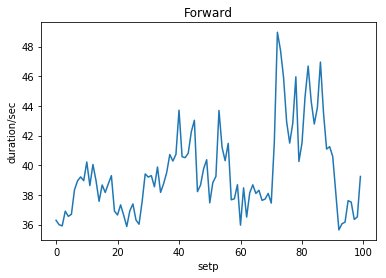

2018-02-13 12:59:32.709999:Forward across 100 steps, 39.538 +/- 2.882 sec / batch


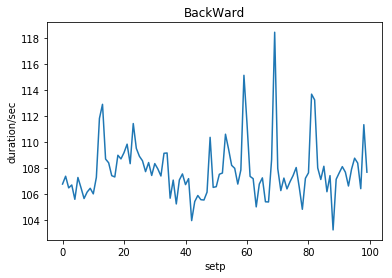

2018-02-13 16:17:52.842748:BackWard across 100 steps, 107.811 +/- 2.222 sec / batch


In [8]:
batch_size = 32
num_batches = 100
run_benchmark()

根据上面的显示，每一个batch在计算前向传播的时候花费将近40s。在计算反向传播的时候花费108s，但是观察上面图像发现在60-90的一段时间耗时明显增加，我估计是因为当时正在解压umdface数据集，因此电脑处理速度跟不上，因此，如果电脑空闲的话我想实际上花费的时间应该会低于上面的时间吧。